In [70]:
import cv2
import numpy as np
import os
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy.linalg
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img)
        plt.title(window_name)
        plt.show()

def display_1_rgb(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()

def display_1_gray(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img, cmap="gray")
    plt.title(name)
    plt.show()

def display_1_img(name:str, img, mode:str="rgb"):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if mode == "gray":
        plt.imshow(img, cmap="gray")
    elif mode == "fire":
        plt.imshow(img, cmap="inferno")
    else:
        plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()




def plot_points(ax, V, fill='lawngreen', alpha=1):
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.scatter(V[:,0], V[:,1], color=fill,
               linewidth=2, s=2, alpha=alpha)    
    return ax

def plot_points_lines(ax, V, fill='lawngreen', alpha=1):
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.scatter(V[:,0], V[:,1], color=fill,
               linewidth=2, s=2, alpha=alpha)
    ax.plot(V_plt[:,0], V_plt[:,1], color=fill,
            linewidth=2, alpha=alpha)
    
    return ax

def display_image_with_points(img, V, title="initial state"):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(121)
    ax.imshow(img[:, :, ::-1])
    ax.set_title(title)
    plot_points(ax, V)

def display_image_with_points_lines(img, V, title="initial state"):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(121)
    ax.imshow(img[:, :, ::-1])
    ax.set_title(title)
    plot_points_lines(ax, V)

## Sheet 08 
 Authors: Siarhei Sheludzko, Marcel Melchers
### 1 Statistical Shape Modeling

Build a PCA based statistical shape model M using the data in *hands_aligned_train.txt*. <br> The data contains a set of 56 corresponding landmark points on hand-contours from 39 instances, <br> which have already been aligned using Procrustes Analysis.  Refer to the *readme* file for details about the data organization. <br>  The model M is formulated by defining the subspace model as:

$$
    w_i≈μ+\sum_{k=1}^{N}\phi_kh_{ik}
$$

$$
    M = \{\mu, \phi_1, \phi_2, ..., \phi_N \}
$$

where $N$ is the minimum number of principal components preserving 90% of the energy. <br> Visualize μ and the effect of the weights $W = (−0.4,−0.2, 0.0, 0.2, 0.4)$ of
each $\phi_k$.

Remarks: Please implement PCA yourself. You may use *np.linalg.eig* and *np.linalg.svd*.

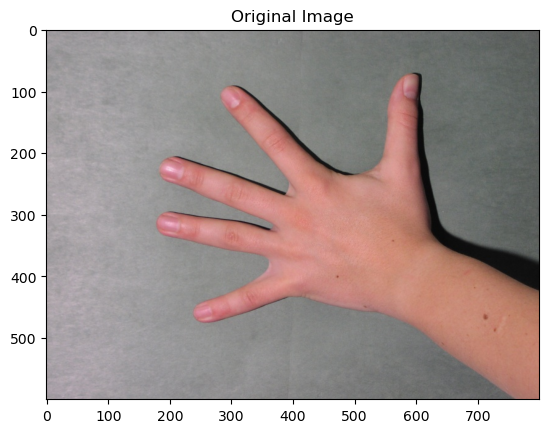

In [2]:
# set image path
path_task1 = './data/task1/hand.jpg'
# read imgs
img_task1 = cv2.imread(path_task1)
display_1_rgb("Original Image", img_task1)


In [3]:
def get_coordinates():
    fpath = './data/task1/hand_landmarks.txt'
    coord_arr = []
    with open(fpath,'r') as f:
        for line in f:
            line = line.replace("(","").replace(")","").strip()
            coord = list(map(int, line.split(",")))
            coord_arr.append(coord)
    return np.array(coord_arr, dtype=np.uint64)

landmark_points = get_coordinates()


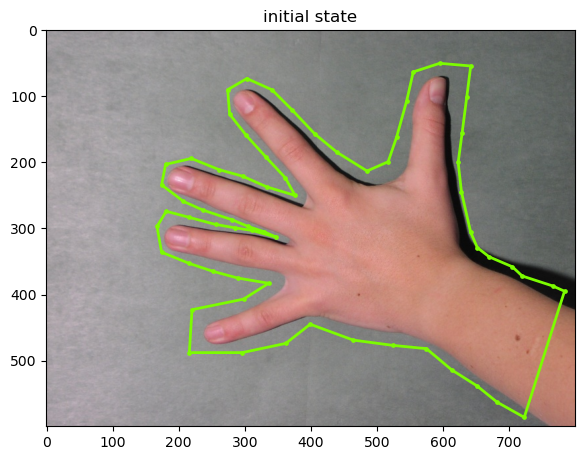

In [72]:
display_image_with_points_lines(img_task1, landmark_points)

In [5]:
def loadData(filename):
    # #return the data points
    # df = pd.read_csv(filename, header = 0)

    # return df
    coord_arr = []
    with open(filename,'r') as f:
        dim = 0
        num = 0
        for i, line in enumerate(f):
            if(i == 0):
                dim , num = list(map(int, line.split("\t")))
            else:
                line = (line.replace("\n", "").split("\t"))
                
                if("train.txt" in filename.split("_")):
                    line = line[:-1]
                coords = list(map(int, line))              
                
                coord_arr.append(coords)   
        coord_arr = np.array(coord_arr, dtype=np.uint64).T
        X_arr = coord_arr[:, :dim//2]
        Y_arr = coord_arr[:, dim//2:]
        coord_arr = np.array([X_arr, Y_arr]).reshape((dim//2, num, 2))
    return coord_arr
    

test_data = loadData('./data/task1/hands_aligned_test.txt')
print("Test Data shape: ", test_data.shape)

train_data = loadData('./data/task1/hands_aligned_train.txt')
print("Train Data shape: ", train_data.shape)

Test Data shape:  (56, 1, 2)
Train Data shape:  (56, 39, 2)


In [6]:
def decomposePCA(dataPoints,  k=None, preservRatio=0.9):
    # implement PCA for task1 yourself and return the first k 
    # components that preserve preservRatio of the energy and their eigen values

    dataPoints = dataPoints.reshape((dataPoints.shape[0]*2, -1))  

    # take one shape as mean shape
    meanShape = np.array([dataPoints[0]])
    

    # subtract mean shape from all shapes
    alignDataPoints = dataPoints - meanShape
    

    # calculate covariance matrix
    covariance_matrix  = np.cov(alignDataPoints)
    # print("Covariance Matrix: ", covariance_matrix.shape)

    # calculate eigen values and eigen vectors of covariance matrix
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    # print("Eigen Values: ", eigen_values.shape)

    # sort eigen values and eigen vectors in descending order
    idx = np.argsort(-eigen_values)
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:,idx]

    
    
    if k is not None and preservRatio is None:
        # return first k components 
        return eigen_values[:k], eigen_vectors[:, :k]

    else:
        # calculate cumulative sum of eigen values of minimum number of principal components preserving 90% of the energy
        eigen_values_total_energy = np.sum(eigen_values)
        cumulative_sum = 0
        counter = 0
        for i in range(len(eigen_values)):
            cumulative_sum += eigen_values[i]
            counter = i+1
            if(cumulative_sum/eigen_values_total_energy >= preservRatio):
                print("Number of principal components preserving 90% of the energy: ", counter)
                break


        # return first k components that preserve preservRatio of the energy and their eigen values
        return eigen_values[:counter], eigen_vectors[:, :counter]

        
        
    
   


     



     
    # U, S, VT = np.linalg.svd(W_WT, full_matrices=True)
    # #if(k is not None):
    # print("S: ", S)
    # print("U: ", U)
    # print("VT: ", VT)

pca_weights, pca_components = decomposePCA(train_data, preservRatio=0.9)



pca_components.shape

Number of principal components preserving 90% of the energy:  11


(112, 11)

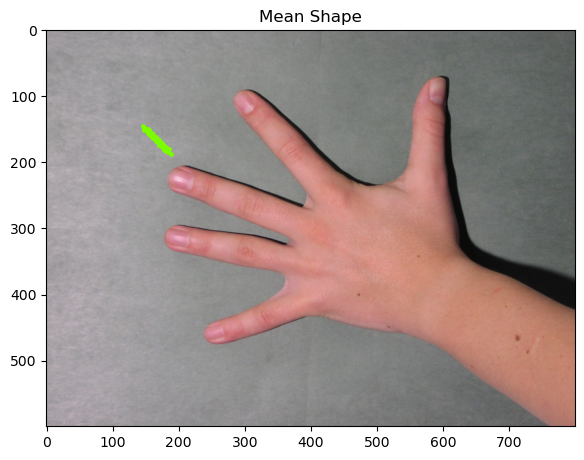

In [7]:
def visualize_mu_and_effect_of_weights(datapoints, mu, pca_components, pca_weights, k):
    # visualize the mean shape and the effect of the first k weights on the mean shape
    # datapoints: the data points
    # mu: the mean shape
    # pca_components: the principal components
    # pca_weights: the weights of the principal components
    # k: the number of principal components to use

    # display the mean shape
    display_image_with_points(img_task1, mu, title="Mean Shape")

    # # display the effect of the first k weights on the mean shape
    # for i in range(k):
    #     display_image_with_points(img_task1, mu + pca_weights[i]*pca_components[:, i], title="Effect of {} weight on mean shape".format(i+1))

visualize_mu_and_effect_of_weights(train_data, train_data.mean(axis=1), pca_components, pca_weights, 5)

### 2 Inference

Given the test shape in *hand_aligned_test.txt* and the generated model
M, estimate the values of $h_{ik}$ using the ICP approach. Also, visualize the reconstructed
shapes and calculate the RMS error between the reconstructed shape and
the original shape for all of the iterations.


### 3 Eigenfaces

In this exercise, we will perform face detection and face recognition
using the Eigenfaces method. Here, you are allowed to use the scikit-learn library.

(a) Use PCA to learn the k principal component of face images in the LFW dataset.
Split the data randomly into 80% for training and 20% for testing. Display
the first 10 Eigenfaces. Find the average reconstruction error of the images
residing in data/task3/detect/face using the k principal components. You
can set k = 100 or any other reasonable value.

In [8]:
lfw_dataset = fetch_lfw_people(min_faces_per_person=0, resize=0.5, download_if_missing=True)

In [9]:
lfw_dataset.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [10]:
items, heught, width = lfw_dataset.images.shape
print("Number of images: ", items)
print("Heught of images: ", heught)
print("Width of images: ", width)

Number of images:  13233
Heught of images:  62
Width of images:  47


In [11]:
X = lfw_dataset.data
y = lfw_dataset.target

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape

(10586, 2914)

In [13]:
first_10_images = X_train[:10]
first_10_images = first_10_images.reshape((10, heught, width))
print("First 10 images shape: ", first_10_images.shape)

First 10 images shape:  (10, 62, 47)


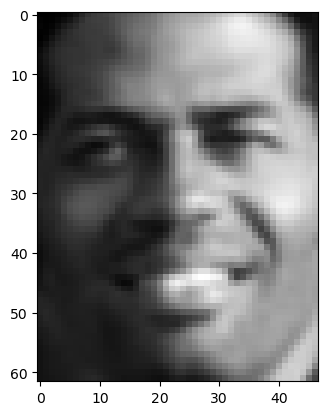

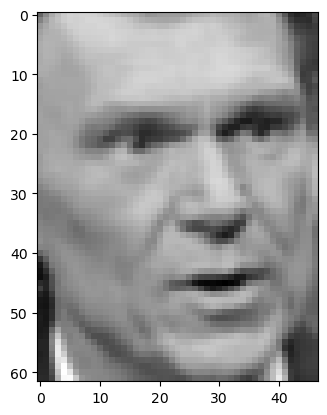

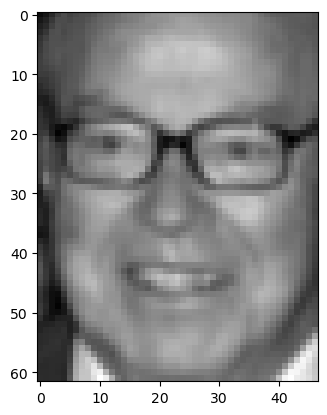

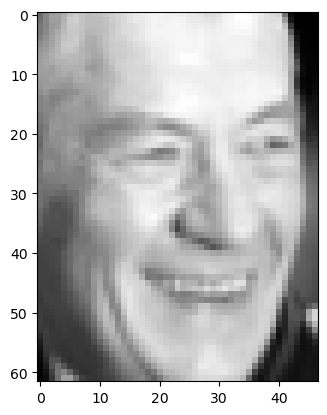

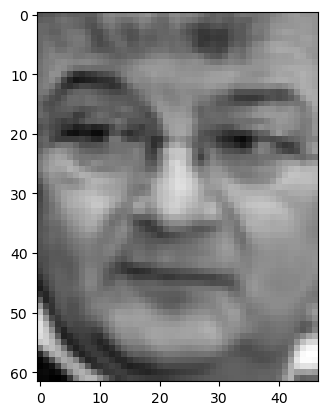

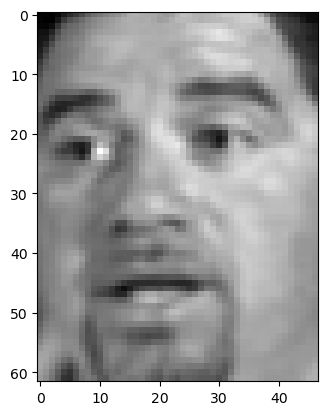

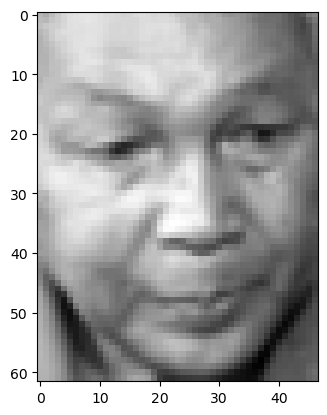

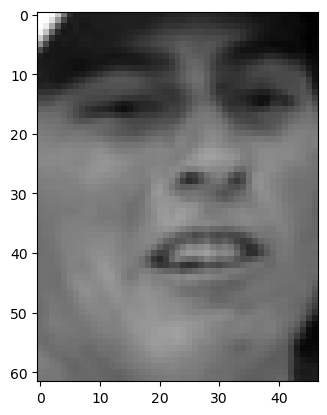

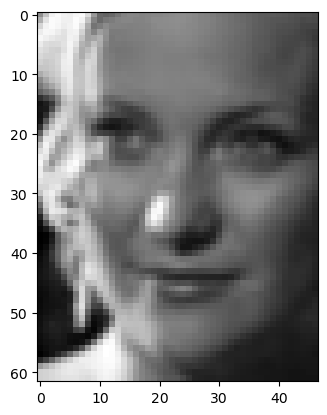

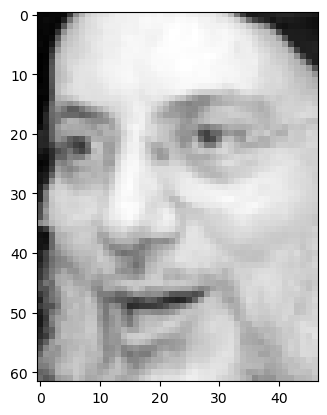

In [14]:
for i in range(first_10_images.shape[0]):
    plt.imshow(first_10_images[i], cmap='gray')
    plt.show()

In [15]:
pca = PCA(n_components=100, whiten=True)
pca.fit(X_train)

PCA(n_components=100, whiten=True)

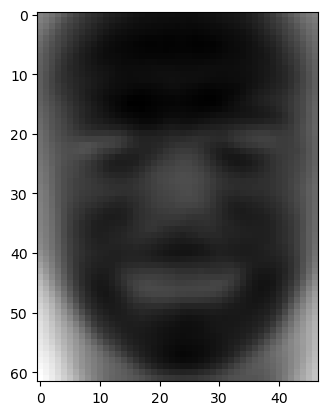

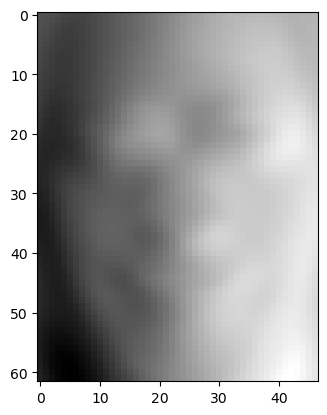

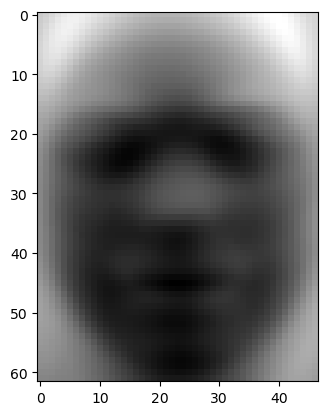

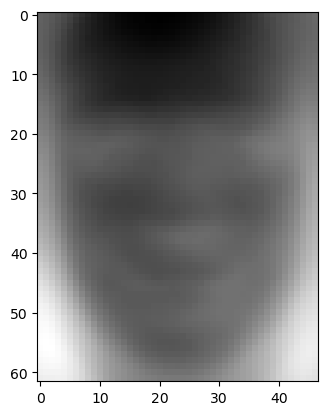

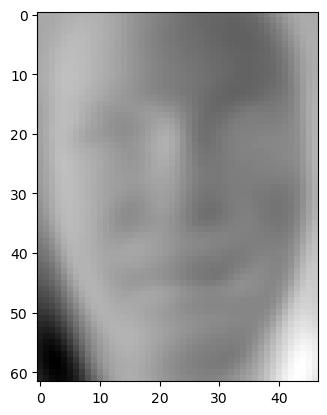

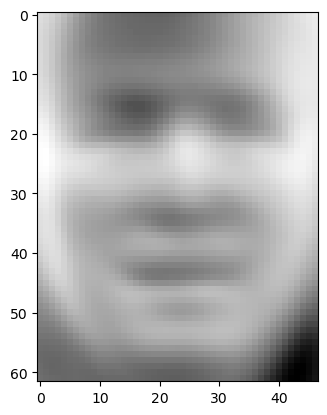

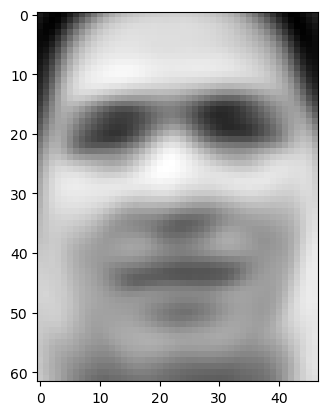

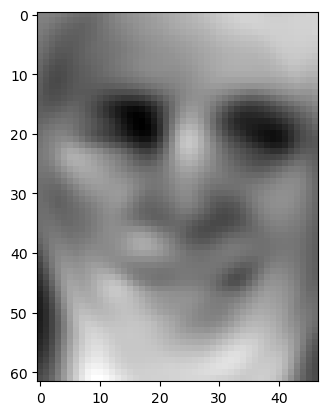

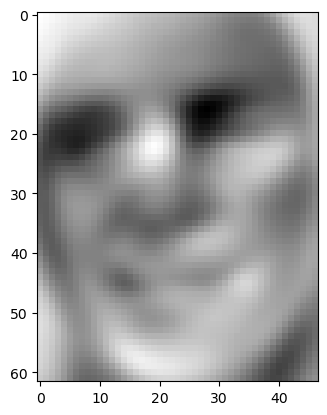

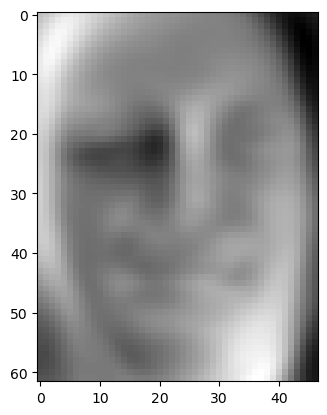

In [16]:
eigenfaces = pca.components_.reshape((100, heught, width))
first_10_eigenfaces = eigenfaces[:10]

for i in range(first_10_eigenfaces.shape[0]):
    plt.imshow(first_10_eigenfaces[i], cmap='gray')
    plt.show()

In [17]:
# find the average reconstruction error of images in path .data/task3/detect/face

def reconstruct_and_compute_error(path, pca, heught, width):
    # reconstruct the images in the given path using the pca and compute the average reconstruction error
    # path: the path to the images
    # pca: the pca object
    # heught: the heught of the images
    # width: the width of the images

    # load the images
    errors_arr = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # cut the padding of the images
            img = cv2.resize(img, (218, 178))
            img = img[18:200, 18:160] # crop the image to 182x142 pixels to make it more similar to the training images


            img = cv2.resize(img, (width, heught))
            #display_1_gray("",img)
            img = img.reshape(1, -1)
            img_pca = pca.transform(img)
            img_reconstructed = pca.inverse_transform(img_pca)
            # print(img_reconstructed.shape)
            # uncomment the following 2 lines to display the reconstructed image
            # img_reconstructed = img_reconstructed.reshape(heught, width)
            # display_1_gray("",img_reconstructed)
            error = np.linalg.norm(img - img_reconstructed)
            # print("Reconstruction error: ", error)
            errors_arr.append(error)
    average_error = np.mean(errors_arr)
    return average_error
            
        


In [18]:
faces_error = reconstruct_and_compute_error("./data/task3/detect/face", pca, heught, width)
print("Average faces reconstruction error: ", faces_error)

Average faces reconstruction error:  1300.823806012938


In [19]:
# just for interest, find the average reconstruction error of images in path .data/task3/detect/notFace
not_faces_error = reconstruct_and_compute_error("./data/task3/detect/notFace", pca, heught, width)
print("Average not faces reconstruction error: ", not_faces_error)

Average not faces reconstruction error:  1246.0634847026643


Interesting, seems like notFace dataset has lower error than face dataset
I think, it is because training dataset has only faces and our custom dataset has heads. And if I understand it right, PCA method is not size indifferent

(b) Using the learned PCA, detect the face images in **data/task3/detect**. The
images are organized into two directories **face** and **notFace** which indicate
whether an image is of a face or not. Calculate the accuracy of your method.

In [20]:


positiveFilenames = os.listdir("./data/task3/detect/face")
negativeFilenames = os.listdir("./data/task3/detect/notFace")

len(positiveFilenames)

68

In [21]:
def reconstruct_and_compute_accuracy(face_path, notFace_path, pca, heught, width):
    # reconstruct the images in the given path using the pca and compute the average reconstruction error
    # path: the path to the images
    # pca: the pca object
    # heught: the heught of the images
    # width: the width of the images

    # load the images
    face_errors_arr = []
    for filename in os.listdir(face_path):
        img = cv2.imread(os.path.join(face_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # cut the padding of the images
            #img = img[18:200, 18:160]

            #print("Image shape: ", img.shape)
            img = cv2.resize(img, (width, heught))
            # display_1_gray("",img)
            img = img.reshape(1, -1)
            img_pca = pca.transform(img)
            img_reconstructed = pca.inverse_transform(img_pca)
            # print(img_reconstructed.shape)
            # uncomment the following 2 lines to display the reconstructed image
            # img_reconstructed = img_reconstructed.reshape(heught, width)
            # display_1_gray("",img_reconstructed)
            error = np.linalg.norm(img - img_reconstructed)
            #print("Reconstruction error: ", error)
            face_errors_arr.append(error)
    
    notFace_errors_arr = []
    for filename in os.listdir(notFace_path):
        img = cv2.imread(os.path.join(notFace_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # cut the padding of the images
            #img = img[18:200, 18:160]

            #print("Image shape: ", img.shape)
            img = cv2.resize(img, (width, heught))
            # display_1_gray("",img)
            img = img.reshape(1, -1)
            img_pca = pca.transform(img)
            img_reconstructed = pca.inverse_transform(img_pca)
            # print(img_reconstructed.shape)
            # uncomment the following 2 lines to display the reconstructed image
            # img_reconstructed = img_reconstructed.reshape(heught, width)
            # display_1_gray("",img_reconstructed)
            error = np.linalg.norm(img - img_reconstructed)
            #print("Reconstruction error: ", error)
            notFace_errors_arr.append(error)
    mean = np.mean(face_errors_arr)
    
    # standard deviation of the errors
    std = np.std(face_errors_arr)
    threshold = mean + std



    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    for error in face_errors_arr:
        if error < threshold:
            true_positives += 1
        else:
            false_negatives += 1
    
    for error in notFace_errors_arr:
        if error < threshold:
            false_positives += 1
        else:
            true_negatives += 1
    
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    print("Accuracy: ", accuracy)

    return accuracy 

accuracy = reconstruct_and_compute_accuracy("./data/task3/detect/face", "./data/task3/detect/notFace", pca, heught, width)


Accuracy:  0.821917808219178


I do not fully understand the idea of calculating of the accuracy in this task.
* Our "dataset" is very unbalanced. We have only 5 samples from "notFace"-class and 68 samples of "face"-class
* Accuracy value depends on threshold a lot (also because of unbalanced dataset)
* "face"-class images distinguish from training data


(c) Using the learned PCA, recognize the images in the test set split, i.e. given
a test face image, find out to whom this face belongs. To do that, apply the
Nearest Neighbor classifier with respect to the training set. Calculate the accuracy
of your recognition method

In [22]:
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)


In [23]:
X_train_transformed.shape

(10586, 100)

In [24]:
X_test_transformed.shape

(2647, 100)

In [25]:


knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(X_train_transformed, y_train)

y_pred = knn_classifier.predict(X_test_transformed)

print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.12202493388741972


c:\Users\schel\anaconda3\envs\cv_env\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [26]:
print("Number of classes in test dataset: ",len(set(y_test)))

Number of classes in test dataset:  1686


Taking into account the number of classes (1686) the accuracy = 12.61% is super good.

### 4. Corner Detectors:
Implementing Harris corner detector and Förstner corner
detector

(a) Implement the structural tensor $ M = \sum w(x, y)
\begin{bmatrix}
I_xI_x & I_xI_y \\
I_xI_y & I_yI_y
\end{bmatrix}
$
, where $I_d$ is
the image gradient in the d direction and w is a convolutional kernel.

In [27]:
def structural_tensor(img , kernel_size=3):
    # compute the structural tensor of the given image
    # img: the image
    # return: the structural tensor of the image

    # compute the gradients of the image
    dy, dx = np.gradient(img)

    # compute the structural tensor of the image
    Ixx = dx * dx
    Ixy = dx * dy
    Iyy = dy * dy

    kernel = np.ones((kernel_size, kernel_size), np.float32) 


    Ixx = cv2.filter2D(Ixx, -1, kernel, borderType=cv2.BORDER_CONSTANT)
    Ixy = cv2.filter2D(Ixy, -1, kernel, borderType=cv2.BORDER_CONSTANT)
    Iyy = cv2.filter2D(Iyy, -1, kernel, borderType=cv2.BORDER_CONSTANT)
    
    # kernel_sums = cv2.filter2D(img, -1, kernel)
    # Ixx *= kernel_sums
    # Ixy *= kernel_sums
    # Iyy *= kernel_sums
    


    return Ixx, Ixy, Iyy

(b) Implement Harris corner detector, then display the response function and the
detected corners of the image **data/task4/palace.jpeg**.

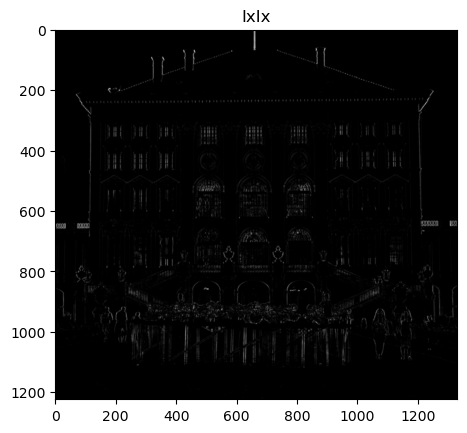

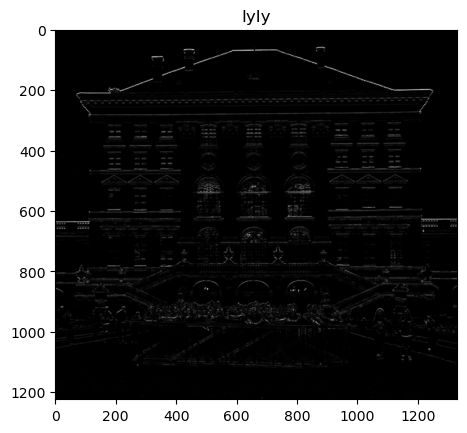

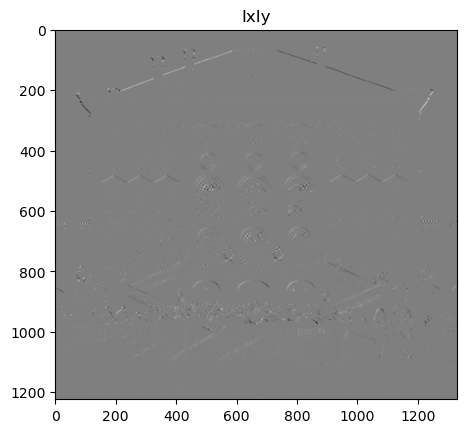

In [28]:
palace_img = cv2.imread("./data/task4/palace.jpeg", cv2.IMREAD_GRAYSCALE)
Ixx, Ixy, Iyy = structural_tensor(palace_img)

display_1_gray("IxIx", Ixx)
display_1_gray("IyIy", Iyy)
display_1_gray("IxIy", Ixy)

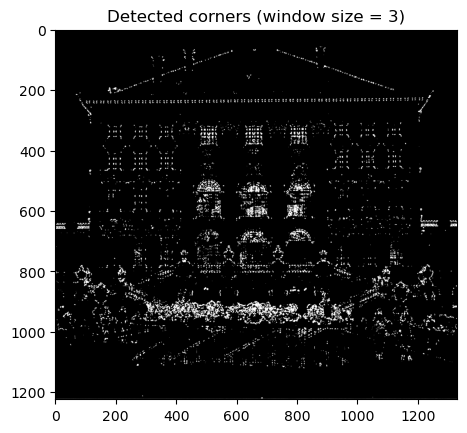

In [34]:
def my_harris_corner_detector(img, window_size, k, threshold):
    # detect the corners in the given image using the harris corner detector
    # img: the image
    # window_size: the size of the window used for the harris corner detector
    # k: the k parameter for the harris corner detector
    # threshold: the threshold for the harris corner detector
    # return: the image with the corners detected and a list of the corner-coordinates
    img = img.copy()

    offset = window_size // 2
    y_range = img.shape[0] - offset
    x_range = img.shape[1] - offset

    corners = []

    # compute the structural tensor of the image
    Ixx, Ixy, Iyy = structural_tensor(img, kernel_size=window_size)

    # iterate over the image
    for y in range(offset, y_range):
        for x in range(offset, x_range):

            # compute the M matrix
            M = np.zeros((2,2))
            M[0,0] = Ixx[y,x]
            M[0,1] = Ixy[y,x]
            M[1,0] = Ixy[y,x]
            M[1,1] = Iyy[y,x]

            # compute the R value
            R = np.linalg.det(M) - k * (np.trace(M) ** 2)

            # if R is greater than the threshold, then it is a corner
            if R > threshold:
                img[y,x] = 255
                corners.append((y, x, R))
            else:
                img[y,x] = 0
    return img, corners

detected_corners_1, corners_list_1 = my_harris_corner_detector(palace_img, 3, 0.05, 800000)
display_1_gray("Detected corners (window size = 3)", detected_corners_1)

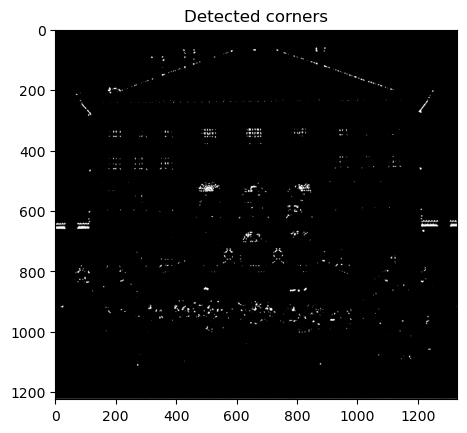

In [33]:
detected_corners_2, corners_list_2 = my_harris_corner_detector(palace_img, 5, 0.05, 100000000)
display_1_gray("Detected corners (window size = 5)", detected_corners_2)

(c) Implement Förstner corner detector and display $w = \frac{det(M)}{Tr(M)}$ and $q = \frac{4det(M)}{Tr(M)^2}$
after thresholding, as well as the detected corners of the palace image. Do you
observe differences to the results obtained by Harris corner detector?

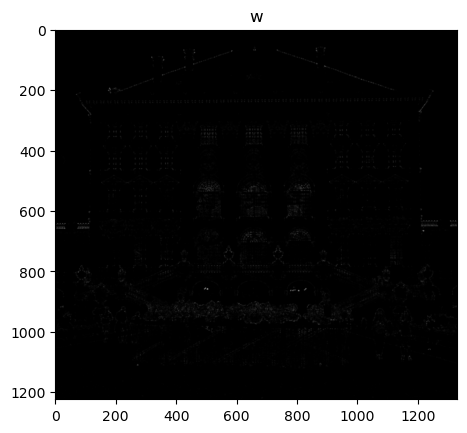

w min:  0.0  w max:  16554.64217923574


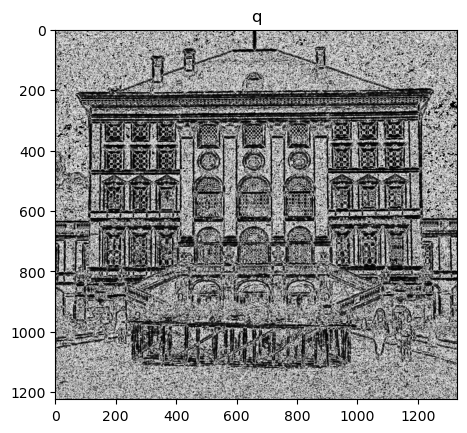

q min:  0.0  q max:  1.0


In [46]:
# calculate det(M)
det_M = Ixx * Iyy - Ixy **2
# calculate trace(M)
trace_M = Ixx + Iyy
# calculate w
w = det_M /(trace_M + .0000000000001) # add a small number to avoid division by zero. Otherwise problem with nan values
# calculate q
q = 4*det_M / (trace_M ** 2 + .0000000000000001)

display_1_gray("w", w)
print("w min: ", np.min(w), " w max: ", np.max(w))
display_1_gray("q", q)
print("q min: ", np.min(q), " q max: ", np.max(q))

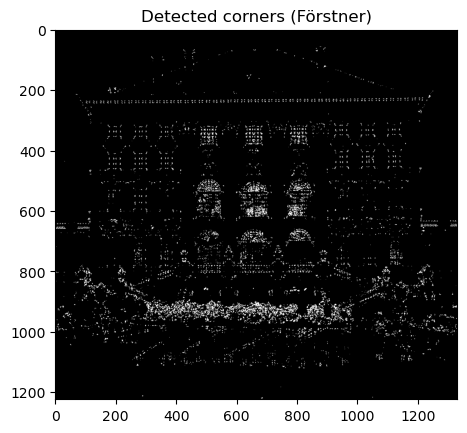

In [80]:
def my_foerstner_corner_detector(img, window_size, q_threshold=0.5, w_threshold=400):
    # detect the corners in the given image using the foerstner corner detector
    # img: the image
    # return: the image with the corners detected and a list of the corner-coordinates
    result = img.copy()
    # compute the structural tensor of the image
    Ixx, Ixy, Iyy = structural_tensor(img, kernel_size=window_size)
    # calculate det(M)
    det_M = Ixx * Iyy - Ixy **2
    # calculate trace(M)
    trace_M = Ixx + Iyy
    # calculate w
    w = det_M /(trace_M + .0000000000001) # add a small number to avoid division by zero. Otherwise problem with nan values
    # calculate q
    q = 4*det_M / (trace_M ** 2 + .0000000000000001)
    # apply threshold to q and w
    q[q < q_threshold] = 0
    q[q >= q_threshold] = 1
    w[w < w_threshold] = 0
    w[w >= w_threshold] = 1
    result = q*w
    return result, np.argwhere(result == 1)



    
    
corners_foerstner, corners_list_foerstner = my_foerstner_corner_detector(palace_img, 3)
display_1_gray("Detected corners (Förstner)", corners_foerstner)


It's difficult to make a direct comparison (find a difference or something like that) of results of Harris and Förstner corner detectors as we have 3 different thresholds

As Prof. Gall told in the lecture, Förstner-Detector is more reliable, because we have 2 parameters